# Medical Cost Prediction

# Imports

In [40]:
# Python
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
import mlflow
from mlflow.tracking import MlflowClient
from tpot import TPOTRegressor

# Set Up MLflow

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("medical_cost_prediction6")
mlflow.autolog()

# Exploratory Data Analysis

In [32]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

logging.info("Loading dataset...")
df = pd.read_csv("insurance.csv")
df.head()

2025-04-05 21:39:13,850 - INFO - Loading dataset...


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [33]:
# Get basic info
df.info()

# Summary statistics for numerical columns
df.describe()

# Frequency count for categorical columns
df['sex'].value_counts(), df['smoker'].value_counts(), df['region'].value_counts(), df['children'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


(sex
 male      676
 female    662
 Name: count, dtype: int64,
 smoker
 no     1064
 yes     274
 Name: count, dtype: int64,
 region
 southeast    364
 southwest    325
 northwest    325
 northeast    324
 Name: count, dtype: int64,
 children
 0    574
 1    324
 2    240
 3    157
 4     25
 5     18
 Name: count, dtype: int64)

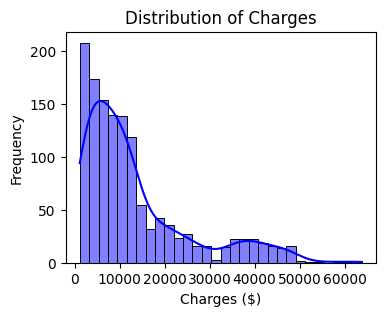

In [43]:
# Distribution of charges
plt.figure(figsize=(4, 3))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Charges')
plt.xlabel('Charges ($)')
plt.ylabel('Frequency')
plt.show()


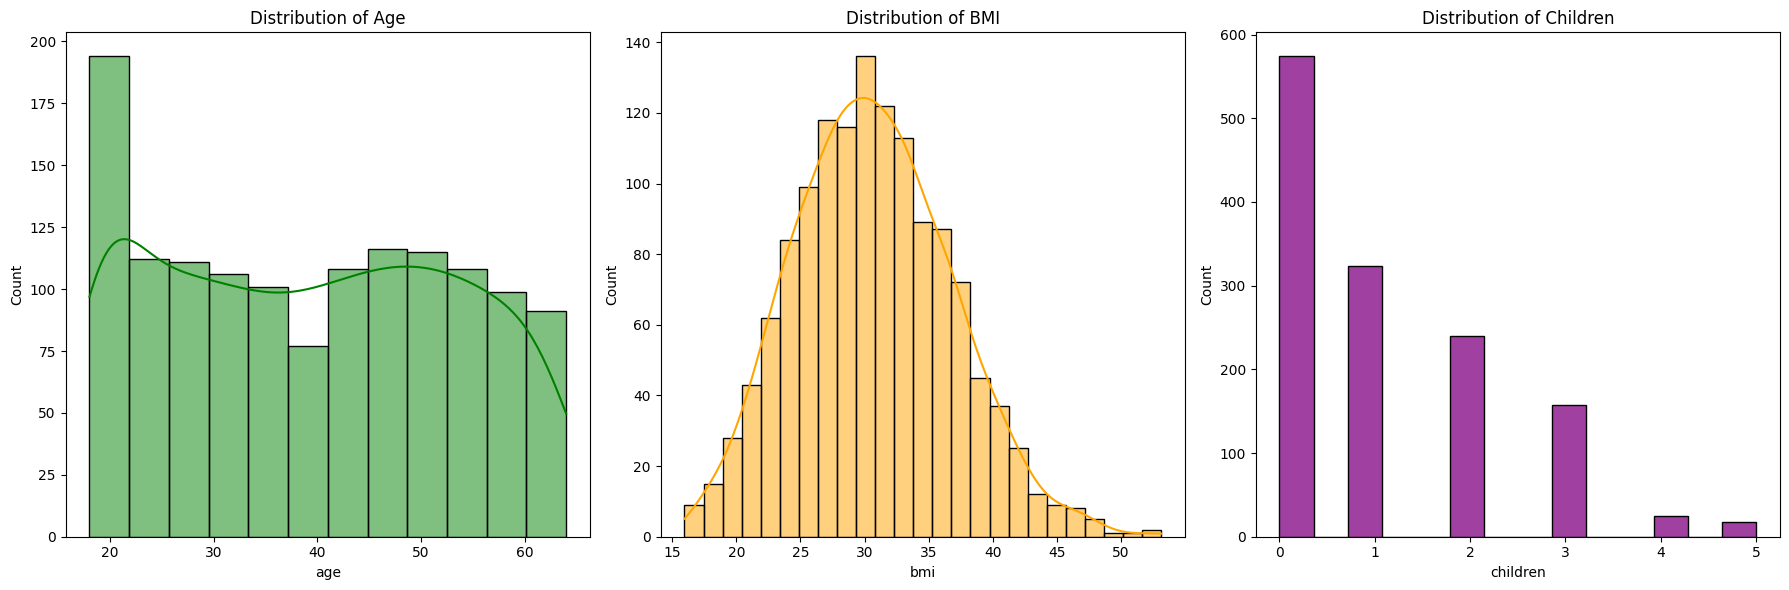

In [44]:
# Distribution of numerical features
plt.figure(figsize=(18, 6))

# Age
plt.subplot(1, 3, 1)
sns.histplot(df['age'], kde=True, color='green')
plt.title('Distribution of Age')

# BMI
plt.subplot(1, 3, 2)
sns.histplot(df['bmi'], kde=True, color='orange')
plt.title('Distribution of BMI')

# Children
plt.subplot(1, 3, 3)
sns.histplot(df['children'], kde=False, color='purple')
plt.title('Distribution of Children')
plt.tight_layout()
plt.show()


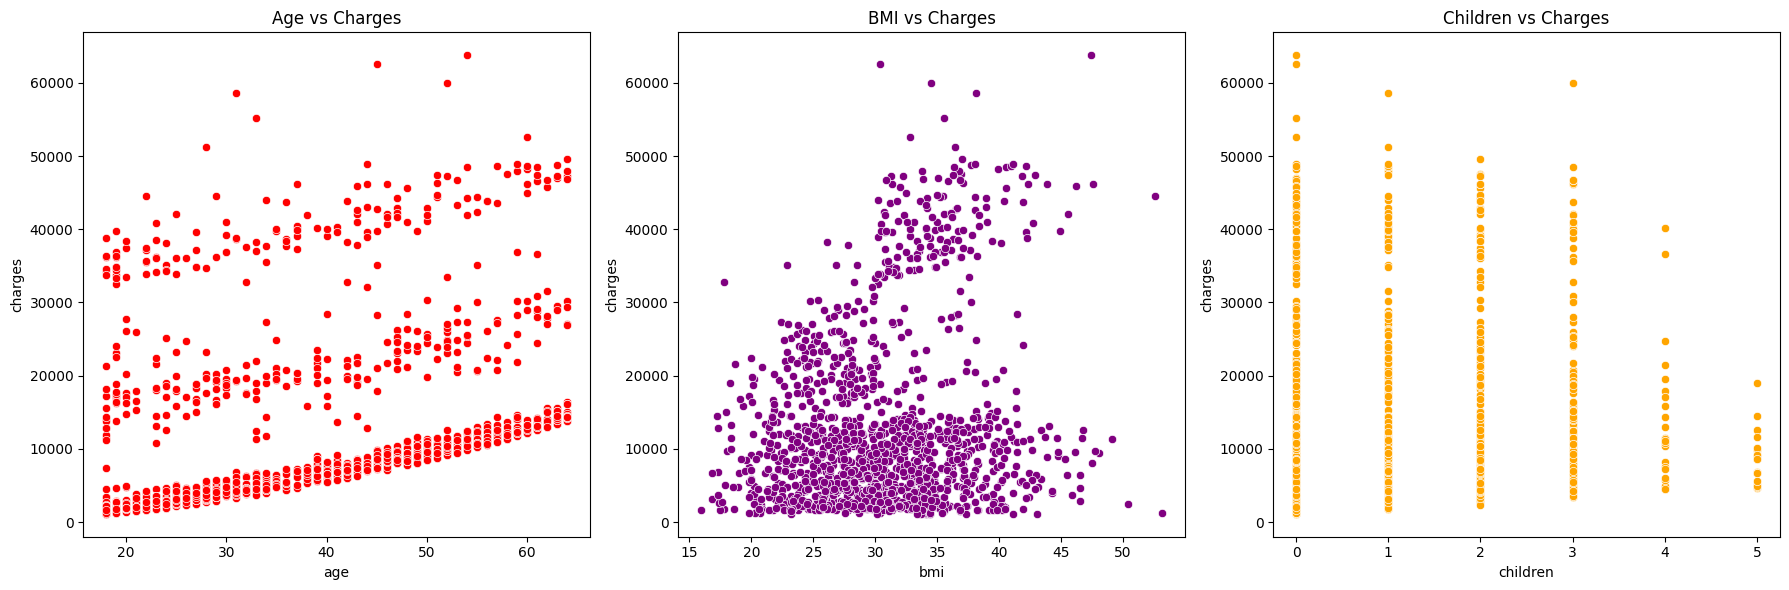

In [45]:
# Scatter plots of numerical features vs charges
plt.figure(figsize=(18, 6))

# Age vs Charges
plt.subplot(1, 3, 1)
sns.scatterplot(x=df['age'], y=df['charges'], color='red')
plt.title('Age vs Charges')

# BMI vs Charges
plt.subplot(1, 3, 2)
sns.scatterplot(x=df['bmi'], y=df['charges'], color='purple')
plt.title('BMI vs Charges')

# Children vs Charges
plt.subplot(1, 3, 3)
sns.scatterplot(x=df['children'], y=df['charges'], color='orange')
plt.title('Children vs Charges')

plt.tight_layout()
plt.show()


/var/folders/h3/4dwpklsd0vq23n7lrrx_lryr0000gn/T/ipykernel_3551/1347751639.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sex', y='charges', data=df, palette='Set2')
/var/folders/h3/4dwpklsd0vq23n7lrrx_lryr0000gn/T/ipykernel_3551/1347751639.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='smoker', y='charges', data=df, palette='Set1')
/var/folders/h3/4dwpklsd0vq23n7lrrx_lryr0000gn/T/ipykernel_3551/1347751639.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='region', y='charges', data=df, palette='Set3')


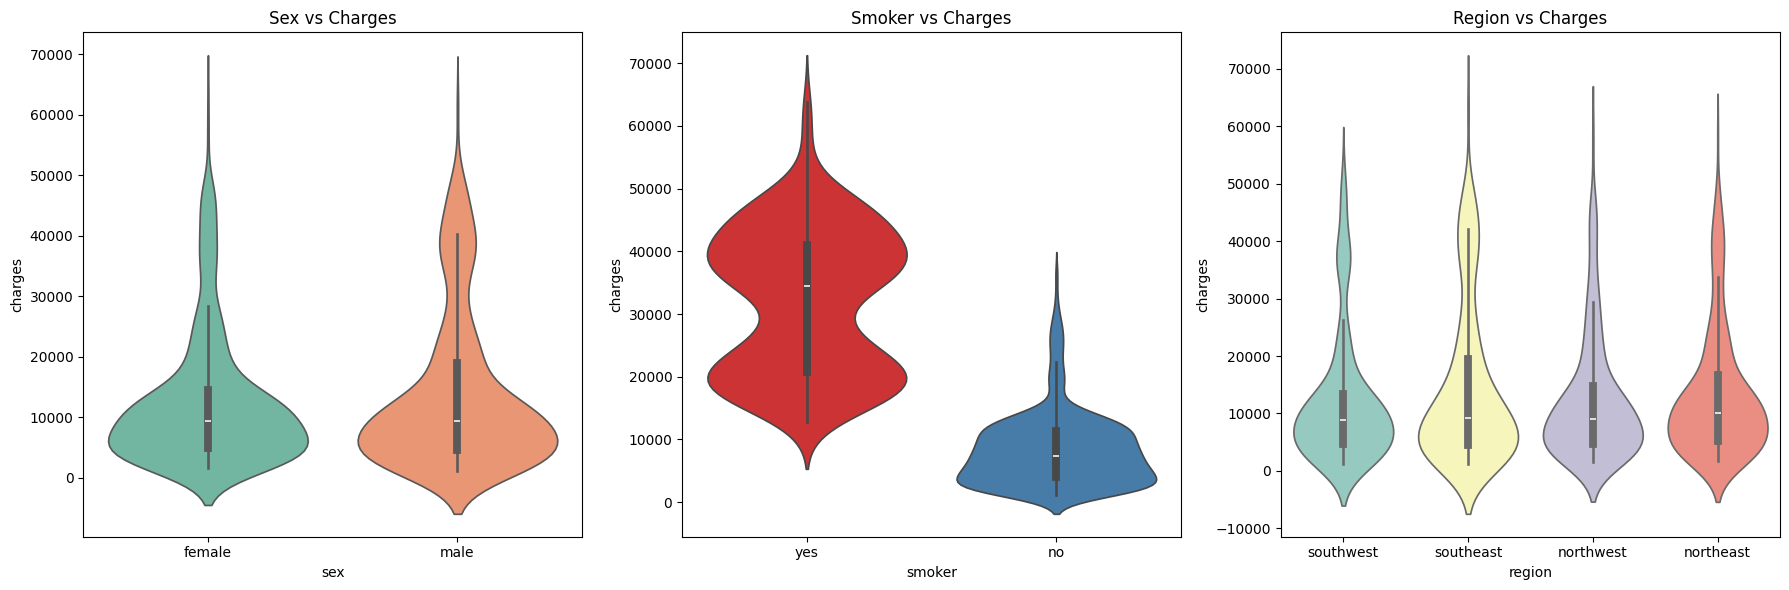

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with 1 row and 3 columns
plt.figure(figsize=(18, 6))

# Plot 1: Sex vs Charges
plt.subplot(1, 3, 1)
sns.violinplot(x='sex', y='charges', data=df, palette='Set2')
plt.title('Sex vs Charges')

# Plot 2: Smoker vs Charges
plt.subplot(1, 3, 2)
sns.violinplot(x='smoker', y='charges', data=df, palette='Set1')
plt.title('Smoker vs Charges')

# Plot 3: Region vs Charges
plt.subplot(1, 3, 3)
sns.violinplot(x='region', y='charges', data=df, palette='Set3')
plt.title('Region vs Charges')

# Adjust layout
plt.tight_layout()

# Show all the plots
plt.show()


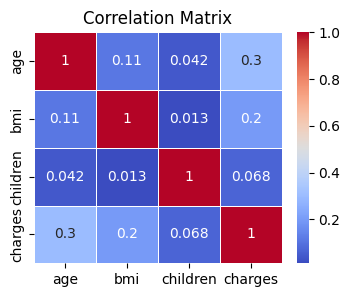

In [53]:
# Correlation matrix
correlation_matrix = df[['age', 'bmi', 'children', 'charges']].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# Prep Data

In [ ]:
X = df.drop(columns=["charges"])
y = df["charges"]

# Step 1: Train-test split (Prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

# Step 2: Define column transformations (One-Hot Encoding + Scaling)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Apply fit_transform only on X_train (to avoid test data leakage)
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)  # Use transform, NOT fit_transform

# Step 3: Feature selection (Only fit on training set)
selector = SelectKBest(score_func=f_regression, k=20)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_test_selected = selector.transform(X_test_encoded)  # Again, transform only

# TPOT

In [ ]:
custom_config = {
    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt'],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_depth': [None, 5, 10],
    },
    'xgboost.XGBRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    },
}

tpot = TPOTRegressor(
    generations=5,
    population_size=10,
    verbosity=2,
    scoring='neg_root_mean_squared_error',
    config_dict=custom_config,  # Pass the custom config
    cv=5,
    random_state=42,
    n_jobs=-1,
)

tpot.fit(X_train_selected, y_train)


# Find the best model with MLflow

In [ ]:
# Set experiment name (replace with your actual experiment name)
experiment_name = "medical_cost_prediction6"
client = MlflowClient()

# Get the experiment details
experiment = client.get_experiment_by_name(experiment_name)

# Fetch all runs and sort by the metric (e.g., "rmse" for lowest error)
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id], 
    order_by=["metrics.training_root_mean_squared_error ASC"],  # Change metric name & sorting direction if needed
    max_results=1  # Get only the best run
)

In [ ]:
# Get the best run ID
best_run = runs[0]
best_run_id = best_run.info.run_id
best_model_uri = f"runs:/{best_run_id}/model"
best_model = mlflow.pyfunc.load_model(best_model_uri)

# Make predictions with the best model
predictions = best_model.predict(X_test_selected)  # Uncomment when using

mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

logging.info(best_run_id)
logging.info("Mean Absolute Error:", mae)
logging.info("RMSE", rmse)
logging.info('R2', r2)

# Register model

In [ ]:
# Register the model with the model registry
model_name = "medical_cost_prediction"  # Name of the model
result = mlflow.register_model(best_model_uri, model_name)

logging.info(f"Model registered with version: {result.version}")


In [ ]:
# Transition model to 'Production' stage
client.transition_model_version_stage(
    name=model_name,      # Registered model name
    version=1,                   # Model version you want to promote
    stage="Production"           # Target stage: "Staging", "Production", "Archived"
)